# Анализ определяющих успешность игры закономерностей

**Магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.   
Задача: выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.**

## Рассмотрим файл с данными

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import plotly.offline as pyo
import plotly.graph_objs as go
import pandas as pd
import plotly.io as pio
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats as st
#pio.renderers.default='notebook'

In [2]:
!python -m pip install "git+https://github.com/javadba/mpld3@display_fix"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/javadba/mpld3 (to revision display_fix) to /tmp/pip-req-build-m8vy7jt8
  Running command git clone -q https://github.com/javadba/mpld3 /tmp/pip-req-build-m8vy7jt8
  Running command git checkout -b display_fix --track origin/display_fix
  Switched to a new branch 'display_fix'
  Branch 'display_fix' set up to track remote branch 'display_fix' from 'origin'.
  Running command git submodule update --init --recursive -q


In [3]:
df = pd.read_csv('games.csv', sep = ',')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [5]:
display(df.head(35))

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


## Предобработка данных

### Приведем названия столбцов к нижнему регистру

In [6]:
df.columns = df.columns.str.lower()


### Обработка пропусков

In [7]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [8]:
# Рассмотрим в процентах
def isna_view (df):
    return  (
                (df.isna().mean()*100)
                .sort_values(ascending=False)
                .to_frame()
                .rename(columns = {0:'percent_space'})
                .style.background_gradient('coolwarm').format("{:.1f}")
            )

isna_view (df)

,percent_space
critic_score,51.3
rating,40.5
user_score,40.1
year_of_release,1.6
name,0.0
genre,0.0
platform,0.0
na_sales,0.0
eu_sales,0.0
jp_sales,0.0


**Так как в столбце name всего два пропуска, то мы можем безболезненно удалить такие строки**

In [9]:
df = df.dropna(subset = ['name']) 

In [10]:
df.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         6699
rating             6764
dtype: int64

**В столбце genre также удалились пропуски, значит, это были одни и те же строки**

**В столбце года выпуска игры 269 пропусков. Заполнить это значение ничем нельзя. Удалим строки, где есть пропуски**

In [11]:
df = df.dropna(subset = ['year_of_release']) 

**Таким образом, у нас осталось 6600 и 8400 пропусков в столбцах с рейтингом. Заполнить такие строки нельзя, так как нет аналогичных значений, чтобы на них опираться. Удалить их тоже нельзя, так как в таком случае  будет удалена почти треть выборки**

**Теперь можно заменить тип столбца year_of_release на целочисленный**

In [12]:
df['year_of_release'] = df['year_of_release'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Возрастное ограничение

**В столбце с возрастным ограничением можно проставить рейтинг в соответствии с жанром игры**

In [13]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

**Разберем ограничения** (*Информация взята с сайта https://4buttonz.ru/esrb-rating-symbols-rejjtingov-dlya-kompyuternykh-videoigr/):
- E - для любого возраста
- E10+ - от 10 лет
- T - от 13 лет
- M - от 17 лет
- AO - от 18 лет
- RP - рейтинг ожидается
- EC - дети раннего возраста
- K-A - для детей и взрослых (уже не используется) (от 6 лет)

**Система ESRB работает на американском рынке, поэтому мы имеем так много пропусков. Производители игр в Японии и Европе не стремятся получить эту отметку**

**Заменим пропуски в этом столбце на "unknown"**

In [14]:
df['rating'] = df['rating'].fillna('unknown')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Оценка "tbd"

**Рассмотрим уникальные значения столбца user_score**

In [15]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

**Рассмотрим срез со значениями "tbd"**

In [16]:
display(df.query('user_score == "tbd"').head(5))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E


**tbd (to be determined) расшифровывается как "подлежит уточнению". Скорее всего это связано с малым количеством проданных копий**

**Заменим знаения tbd на NaN**

In [17]:
def score_tbd(row):
    score = row['user_score']
    if score == 'tbd':
        return np.nan
    return score
df['user_score'] = df.apply(score_tbd, axis = 1)

**Теперь можно заменить тип столбца user_score на float**

In [18]:
df['user_score'] = df['user_score'].astype('float')

### Расчет суммарных продаж во всех регионах

In [19]:
df['sum_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

## Исследовательский анализ данных

### Рассмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [20]:
# Составим сводную таблицу, которая покажет количество игр по годам выпуска
df_group = df.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')

# Составим по сводной таблице DF для построения графика
result_df_group = pd.DataFrame({'Год выпуска':df['year_of_release'].sort_values().unique(), 'Количество игр': df_group['name']})

display(result_df_group)

,Год выпуска,Количество игр
year_of_release,,
1980,1980,9
1981,1981,46
1982,1982,36
1983,1983,17
1984,1984,14
1985,1985,14
1986,1986,21
1987,1987,16
1988,1988,15


**Выведем график по полученному DF**

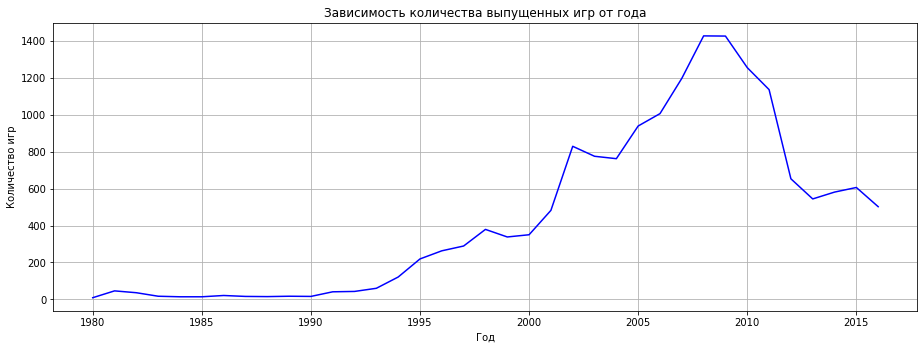

In [21]:
fig = plt.figure()

axes = fig.add_axes([0.1, 0.1, 2, 1]) 

x = result_df_group['Год выпуска'] 
y = result_df_group['Количество игр']

axes.plot(x, y, 'b')
axes.grid(True)
axes.set_xlabel('Год')
axes.set_ylabel('Количество игр')
axes.set_title('Зависимость количества выпущенных игр от года'); 

**Изучив график можно сделать вывод, что количество выпущенных игр непрерывно увеличивалось вплоть до 2009 года, после чего количество уменьшалось до 2016г.**

### Продажи по платформам 

**У платформы DS обнаружен странный выброс 1985 года. В это время ее даже не существовало. Удалим это значение**

In [22]:
df.query('platform == "DS" and year_of_release == 1985')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,unknown,0.02


In [23]:
df = df.loc[(df['year_of_release'] != 1985) | (df['platform'] != "DS")]

**Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?**

In [24]:
# Сгруппируем таблицу по годам и по продажам
df_platform = df.groupby(['platform', 'year_of_release']).agg({'sum_sales': 'sum'})
#display(df_platform.head(55))

# Теперь соберем таблицу, в которой будут собраны 10 платформ с наибольшими суммарными продажами
df_platform_2 = df.groupby(['platform']).agg({'sum_sales': 'sum'}).sort_values(by = 'sum_sales', ascending = False)
df_platform_2 = df_platform_2.query('sum_sales > 256').sort_values(by = 'sum_sales', ascending = False)
#display(df_platform_2.head(55))

# Готовая таблица для построения графика количества игр по самым популярным платформам по годам
result_df_platform = df_platform.query('platform in @df_platform_2.index').reset_index()
#display(result_df_platform.head(55))

# Теперь соберем данные по каждой платформе в отдельный DF
data_3DS = result_df_platform[result_df_platform['platform'] == '3DS']
data_DS = result_df_platform[result_df_platform['platform'] == 'DS']
data_GBA = result_df_platform[result_df_platform['platform'] == 'GBA']
data_PSP = result_df_platform[result_df_platform['platform'] == 'PSP']
data_PS = result_df_platform[result_df_platform['platform'] == 'PS']
data_PS2 = result_df_platform[result_df_platform['platform'] == 'PS2']
data_PS3 = result_df_platform[result_df_platform['platform'] == 'PS3']
data_PS4 = result_df_platform[result_df_platform['platform'] == 'PS4']
data_Wii = result_df_platform[result_df_platform['platform'] == 'Wii']
data_X360 = result_df_platform[result_df_platform['platform'] == 'X360']

**Построим график, в котором будет содержаться вся информация по интересующим нас платформам**

In [25]:
# Теперь построим график по таблицам

pl_3DS = go.Scatter(x = data_3DS['year_of_release'],
                            y = data_3DS['sum_sales'],
                            name = '3DS')

pl_DS = go.Scatter(x=data_DS['year_of_release'],
                            y = data_DS['sum_sales'],
                            name = 'DS')

pl_GBA = go.Scatter(x = data_GBA['year_of_release'],
                            y = data_GBA['sum_sales'],
                            name = 'GBA')

pl_PSP = go.Scatter(x = data_PSP['year_of_release'],
                            y = data_PSP['sum_sales'],
                            name = 'PSP')

pl_PS = go.Scatter(x = data_PS['year_of_release'],
                            y = data_PS['sum_sales'],
                            name = 'PS')

pl_PS2 = go.Scatter(x = data_PS2['year_of_release'],
                            y = data_PS2['sum_sales'],
                            name = 'PS2')

pl_PS3 = go.Scatter(x = data_PS3['year_of_release'],
                            y = data_PS3['sum_sales'],
                            name = 'PS3')

pl_PS4 = go.Scatter(x = data_PS4['year_of_release'],
                            y = data_PS4['sum_sales'],
                            name = 'PS4')

pl_Wii = go.Scatter(x = data_Wii['year_of_release'],
                            y = data_Wii['sum_sales'],
                            name = 'Wii')

pl_X360 = go.Scatter(x = data_X360['year_of_release'],
                            y = data_X360['sum_sales'],
                            name = 'X360')


pyo.iplot([pl_3DS, pl_DS, pl_GBA, pl_PSP, pl_PS, pl_PS2, pl_PS3, pl_PS4, pl_Wii, pl_X360])


**"Бум" в продажах появляется в районе нулевых годов. Также можно заметить, что как только появляется новая модель (особенно ярко это видно с PS, PS2, PS3, PS4) старая быстро теряет популярность. "Среднее время жизни" платформы составляет около 8 лет, после чего ее заменяют более новые преемники, либо обновленные модели других платформ**

**Пусть актуальный период - последние 4 года (2013-2016). Тогда рассмотрим график в этом диапазоне. Как можно заметить, продажи всех платформ идут на спад. Значит, нужно рассмотреть и остальные платформы, которые не так преуспели в продажах, но могут только набирать свою популярность**

In [26]:
df_px = df.query('year_of_release >= 2013')\
    .groupby(['platform', 'year_of_release'])['sum_sales'].sum().reset_index()

fig = px.line(df_px, x='year_of_release', y='sum_sales', color='platform')

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 2014,
        dtick = 1
    )
)

fig.show();

**Можно сделать вывод, что актуальными платформами на следующий год будут:**  
**(PS3 из списка можно исключить, так как набирает популярность PS4, значит продажи PS3 в 2017 упадут еще сильнее)**
- PS4 (с наибльшим числом продаж за последние два года, причем с сильным отрывом)
- XOne
- 3DS
- PC
- WiiU
- PSV
- X360


### Box-and-whiskers diagram

**Рассмотрим все актуальные платформы (2014 - 2016)**

In [27]:
# Таблица для графика с выбросами
df_platform_3_1 = df.query('year_of_release > 2013')

# Таблица для графика без выбросов
df_platform_3_2 = df.query('year_of_release > 2013 and sum_sales < 2')

In [28]:
# График с выбросами 
fig = go.Figure()
fig.add_trace(go.Box(x = df_platform_3_1['platform'], y = df_platform_3_1['sum_sales']))
fig.update_layout(title = "box-and-whiskers diagram with release",
                  xaxis_title = "Платформы",
                  yaxis_title = "Продажи")
fig.show()

# График без выбросов
fig = go.Figure()
fig.add_trace(go.Box(x = df_platform_3_2['platform'], y = df_platform_3_2['sum_sales']))
fig.update_layout(title = "box-and-whiskers diagram without release",
                  xaxis_title = "Платформы",
                  yaxis_title = "Продажи")
fig.show()

**Приличную часть занимают выбросы, поэтому построено два графика.
Самый большой размах принадлежит платформе XOne(1.12), однако медиана находится сильно ниже(0.15). Это значит, что примерно половина продаж находится в диапазоне от 0.01 до 0.15. Если грубо взглянуть на графики, то можно сделать вывод, что медиана и большинство значений находится в диапазоне 0.01 до 0.15**

### Влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков

**На рассмотрение возьмем платформу PS4, так как она самая популярная за актуальный период**

In [29]:
df_influence_PS4 = df.query('platform == "PS4"')

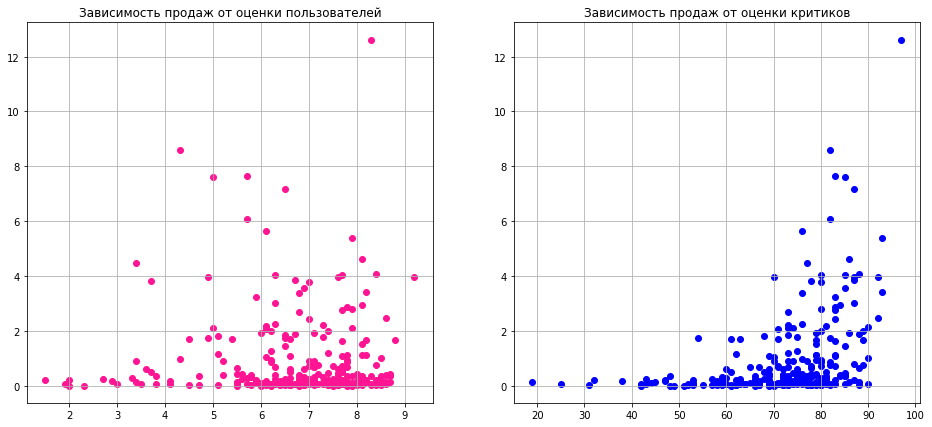

In [30]:
fig, ax = plt.subplots(1,2,figsize=(16,7))

ax[0].scatter(df_influence_PS4['user_score'],
           df_influence_PS4['sum_sales'],
           c = 'deeppink')
ax[1].scatter(df_influence_PS4['critic_score'],
           df_influence_PS4['sum_sales'],
           c = 'b') 
ax[0].set_facecolor('w')
ax[0].set_title('Зависимость продаж от оценки пользователей')
ax[0].grid(True)

ax[1].set_facecolor('w')
ax[1].set_title('Зависимость продаж от оценки критиков')
ax[1].grid(True)

plt.show()

**Расчет коэффициента корреляции**

In [31]:
print(df_influence_PS4['sum_sales'].corr(df_influence_PS4['critic_score']))
print(df_influence_PS4['sum_sales'].corr(df_influence_PS4['user_score']))

0.406567902061781
-0.031957110204556424


**Между продажами и оценками критиков зависимость прямая слабая, а между продажами и оценками пользователей зависимости не наблюдается вообще  
В столбцах с рейтингом очень много пропусков, поэтому такая оценка может быть неточной. Стоит заметить, что чем выше оценка, тем больше продажи. А игры с самыми высокими продажами находятся только в диапазоне высоких рейтингов критиков**

**Рассмотрим ближайших конкурентов**
- XOne
- 3DS

In [32]:
df_influence_XOne = df.query('platform == "XOne"')
df_influence_3DS = df.query('platform == "3DS"')

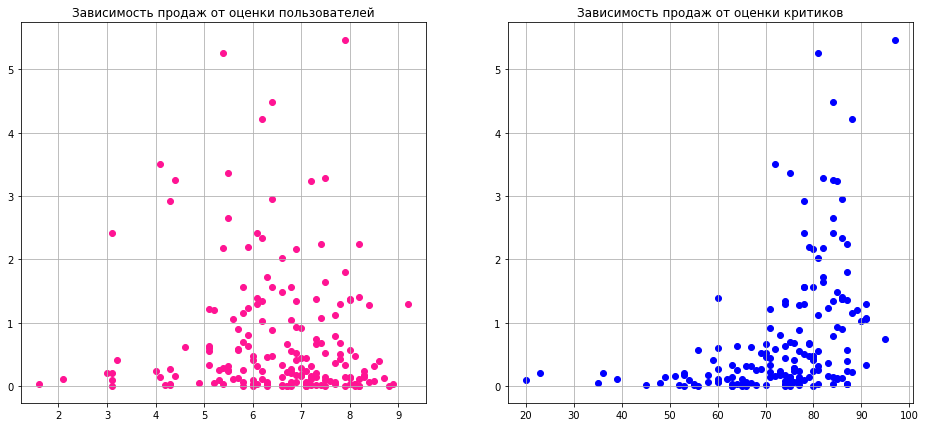

In [33]:
fig, ax = plt.subplots(1,2,figsize=(16,7))

ax[0].scatter(df_influence_XOne['user_score'],
           df_influence_XOne['sum_sales'],
           c = 'deeppink')
ax[1].scatter(df_influence_XOne['critic_score'],
           df_influence_XOne['sum_sales'],
           c = 'b')

ax[0].set_facecolor('w')
ax[0].set_title('Зависимость продаж от оценки пользователей')
ax[0].grid(True)

ax[1].set_facecolor('w')
ax[1].set_title('Зависимость продаж от оценки критиков')
ax[1].grid(True)

plt.show()

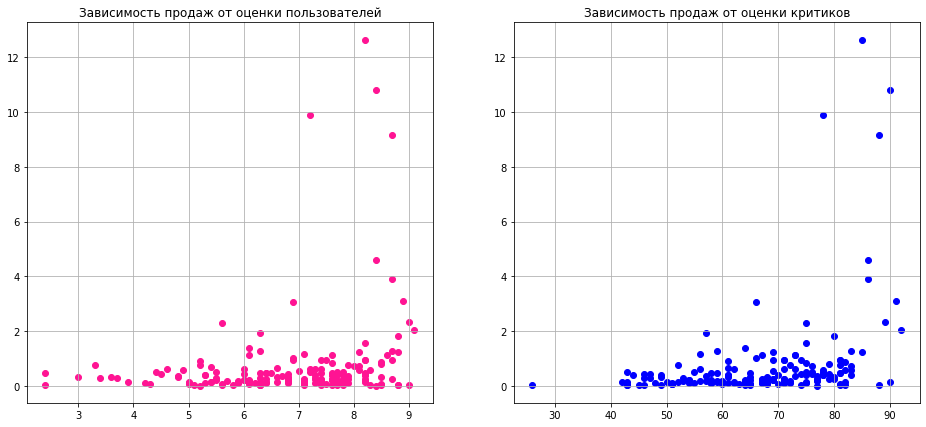

In [34]:
fig, ax = plt.subplots(1,2,figsize=(16,7))

ax[0].scatter(df_influence_3DS['user_score'],
           df_influence_3DS['sum_sales'],
           c = 'deeppink')
ax[1].scatter(df_influence_3DS['critic_score'],
           df_influence_3DS['sum_sales'],
           c = 'b')
ax[0].set_facecolor('w')
ax[0].set_title('Зависимость продаж от оценки пользователей')
ax[0].grid(True)

ax[1].set_facecolor('w')
ax[1].set_title('Зависимость продаж от оценки критиков')
ax[1].grid(True)

plt.show()

**Расчет коэффициента корреляции**

In [35]:
print('Коэффициент корреляции для платформы XOne')
print(df_influence_XOne['sum_sales'].corr(df_influence_XOne['critic_score']))
print(df_influence_XOne['sum_sales'].corr(df_influence_XOne['user_score']))

print('\n')

print('Коэффициент корреляции для платформы 3DS')
print(df_influence_3DS['sum_sales'].corr(df_influence_3DS['critic_score']))
print(df_influence_3DS['sum_sales'].corr(df_influence_3DS['user_score']))

Коэффициент корреляции для платформы XOne
0.41699832800840175
-0.06892505328279412


Коэффициент корреляции для платформы 3DS
0.34873973059848346
0.22207843643390884


**В целом, у конкурентов ситуация идентичная.  
Слабая прямая зависимость продаж от оценки критинков и непрослеживающаяся зависимость от оценки пользователей**

### Распределение игр по жанрам

In [36]:
# График с выбросами
fig = go.Figure()
fig.add_trace(go.Box(x = df_platform_3_1['genre'], y = df_platform_3_1['sum_sales']))
fig.update_layout(title = "box-and-whiskers diagram with release",
                  xaxis_title = "Жанры",
                  yaxis_title = "Продажи")
fig.show()

# График без выбросов
fig = go.Figure()
fig.add_trace(go.Box(x = df_platform_3_2['genre'], y = df_platform_3_2['sum_sales']))
fig.update_layout(title = "box-and-whiskers diagram without release",
                  xaxis_title = "Жанры",
                  yaxis_title = "Продажи")
fig.show()

**Самый большой размах принадлежит жанру Shooter (1.53), примерно 50% значений которого лежит выше 0,365. Также стоит отметить огромное количество выбросов жанра Action, появившихся вследствие низкой медианы и большого числа значений ниже нее. То же самое можно сказать и про Role-Playing и Sports.**

## Портрет пользователя каждого региона

### Самые популярные платформы для пользователя каждого региона

**Создадим три сводные таблицы, демонстрирующие продажи в отдельно взятом регионе**

In [37]:
sales_na = df_platform_3_1.pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum')\
        .sort_values(by = 'na_sales', ascending = False).reset_index()
sales_eu = df_platform_3_1.pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum')\
        .sort_values(by = 'eu_sales', ascending = False).reset_index()
sales_jp = df_platform_3_1.pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum')\
        .sort_values(by = 'jp_sales', ascending = False).reset_index()


In [38]:
#display(sales_na.head(10))
#display(sales_eu.head(10))
#display(sales_jp.head(10))

**Видоизменим таблицы: все, что не вошло в ТОП-5 объединим в категорию "другие"**

In [39]:
# Посчитаем суммарные продажи для не ТОП-5

# Для Северной Америки
other_na = sales_na['na_sales'].sum()
for i in range(5):
    other_na = other_na - sales_na['na_sales'][i]
print(other_na)

# Для Европы
other_eu = sales_eu['eu_sales'].sum()
for j in range(5):
    other_eu = other_eu - sales_eu['eu_sales'][i]
print(other_eu)

# Для Японии
other_jp = sales_jp['jp_sales'].sum()
for k in range(5):
    other_jp = other_jp - sales_jp['jp_sales'][i]
print(other_jp)

31.189999999999994
190.07999999999993
56.53999999999999


In [40]:
# Сократим таблицы до шести строк
sales_na = sales_na.loc[:5,:]
sales_eu = sales_eu.loc[:5,:]
sales_jp = sales_jp.loc[:5,:]

# Заменим шестую строку: платформа - другие, продажи - сумма из предыдущего пункта
sales_na['platform'][5] = 'Другие'
sales_na['na_sales'][5] = other_na

sales_eu['platform'][5] = 'Другие'
sales_eu['eu_sales'][5] = other_eu

sales_jp['platform'][5] = 'Другие'
sales_jp['jp_sales'][5] = other_jp

**Для наглядности построим график**

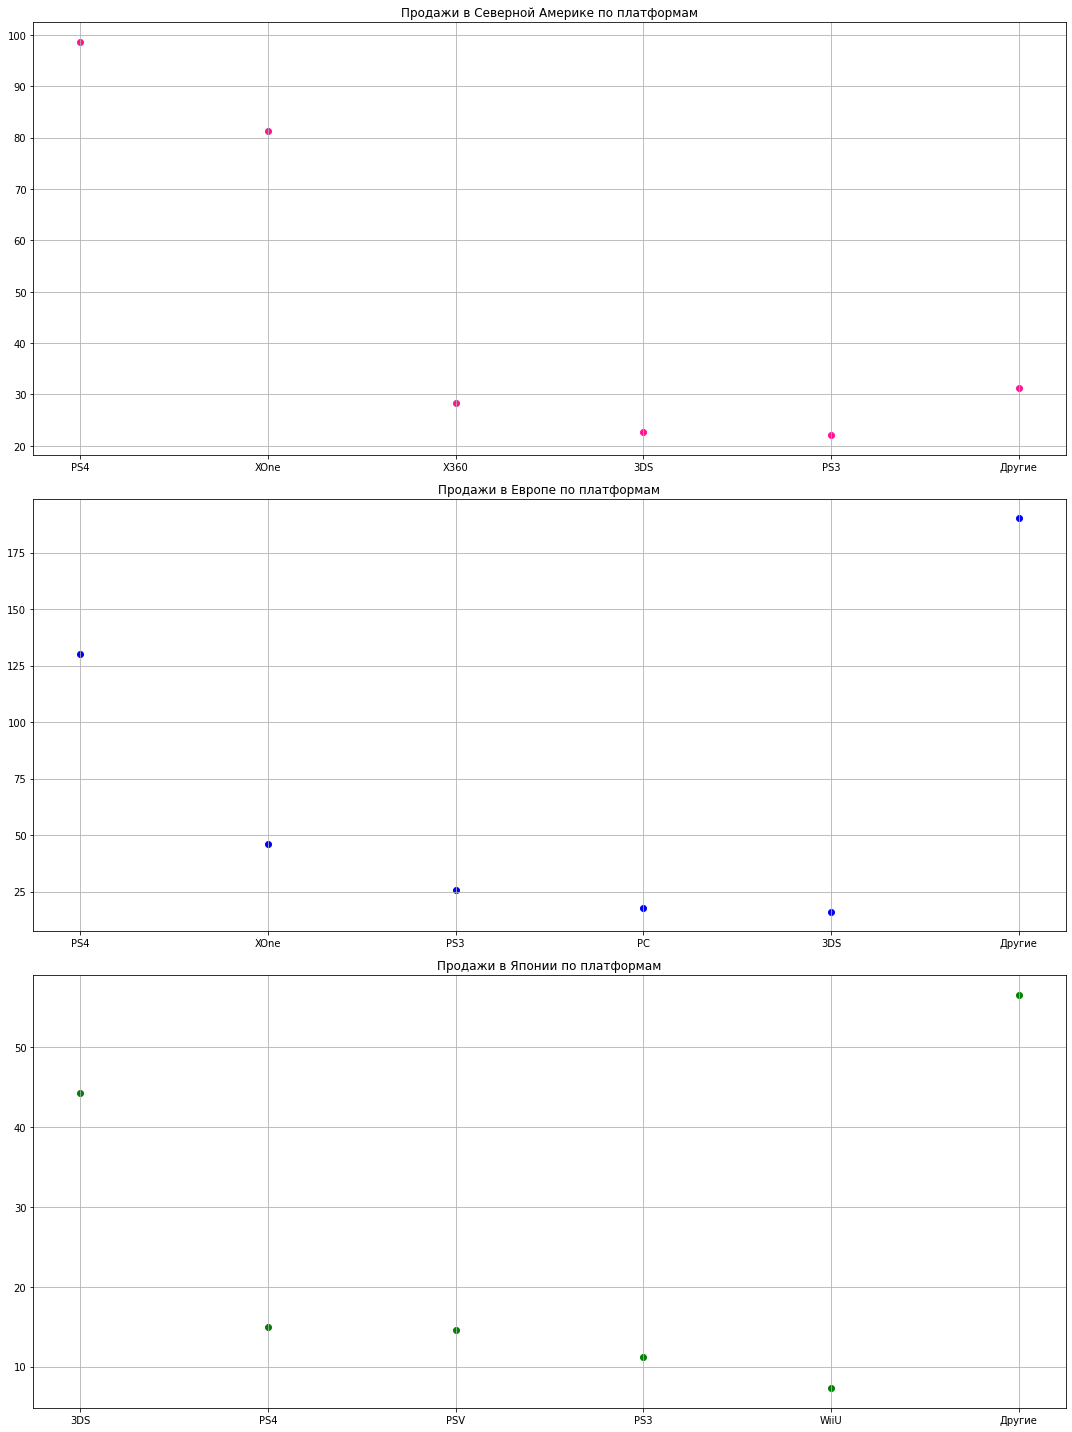

In [41]:
fig, ax = plt.subplots(3, 1, figsize = (15,20))

ax[0].scatter(sales_na['platform'],
           sales_na['na_sales'],
           c = 'deeppink')

ax[1].scatter(sales_eu['platform'],
           sales_eu['eu_sales'],
           c = 'b')

ax[2].scatter(sales_jp['platform'],
           sales_jp['jp_sales'],
           c = 'g')

ax[0].set_facecolor('w')
ax[0].set_title('Продажи в Северной Америке по платформам')
ax[0].grid(True)

ax[1].set_facecolor('w')
ax[1].set_title('Продажи в Европе по платформам')
ax[1].grid(True)

ax[2].set_facecolor('w')
ax[2].set_title('Продажи в Японии по платформам')
ax[2].grid(True)

fig.tight_layout();
plt.show()

**В Северной Америке лидером по продажам стала PS4, причем эта платформа обогнала по продажам все платформы, не входящие в топ-5, вместе взятые. Продажи XOne не дотягивают до по продажам до PS4, но уверенно держатся позади. Примерно на одном уровне на 50 млн ниже находятся платформы X360, 3DS, PS3, "Другие".  
В Европе ситуация другая: Категория "другие" занимает первое место, но фаворитом в одиночных продажах остается PS4, на порядок ниже которой колеблются XOne, PS3, PC и 3DS.  
В Японии категория "Другие" лидирует, а на втором месте по продажам находится платформа 3DS, конкуренты которой колеблются на одном уровне на 30-40 млн ниже: PS4, PSV, PS3, WiiU**

### Самые популярные жанры для пользователей каждого региона

**Создадим три сводные таблицы, демонстрирующие продажи игр по жанрам в отдельно взятом регионе**

In [42]:
genres_na = df_platform_3_1.pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum')\
        .sort_values(by = 'na_sales', ascending = False).reset_index()
genres_eu = df_platform_3_1.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum')\
        .sort_values(by = 'eu_sales', ascending = False).reset_index()
genres_jp = df_platform_3_1.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum')\
        .sort_values(by = 'jp_sales', ascending = False).reset_index()

In [43]:
#display(genres_na.head(5))
#display(genres_eu.head(5))
#display(genres_jp.head(5))

**Видоизменим таблицы: все, что не вошло в ТОП-5 объединим в категорию "другие"**

In [44]:
# Посчитаем суммарные продажи для не ТОП-5

# Для Северной Америки
other_na_genre = genres_na['na_sales'].sum()
for i in range(5):
    other_na_genre = other_na_genre - genres_na['na_sales'][i]
print(other_na_genre)

# Для Европы
other_eu_genre = genres_eu['eu_sales'].sum()
for j in range(5):
    other_eu_genre = other_eu_genre - genres_eu['eu_sales'][i]
print(other_eu_genre)

# Для Японии
other_jp_genre = genres_jp['jp_sales'].sum()
for k in range(5):
    other_jp_genre = other_jp_genre - genres_jp['jp_sales'][i]
print(other_jp_genre)

37.86000000000003
200.03000000000003
68.74


In [45]:
# Сократим таблицы до шести строк
genres_na = genres_na.loc[:5,:]
genres_eu = genres_eu.loc[:5,:]
genres_jp = genres_jp.loc[:5,:]

# Заменим шестую строку: платформа - другие, продажи - сумма из предыдущего пункта
genres_na['genre'][5] = 'Другие'
genres_na['na_sales'][5] = other_na_genre

genres_eu['genre'][5] = 'Другие'
genres_eu['eu_sales'][5] = other_eu_genre

genres_jp['genre'][5] = 'Другие'
genres_jp['jp_sales'][5] = other_jp_genre

**Построим график**

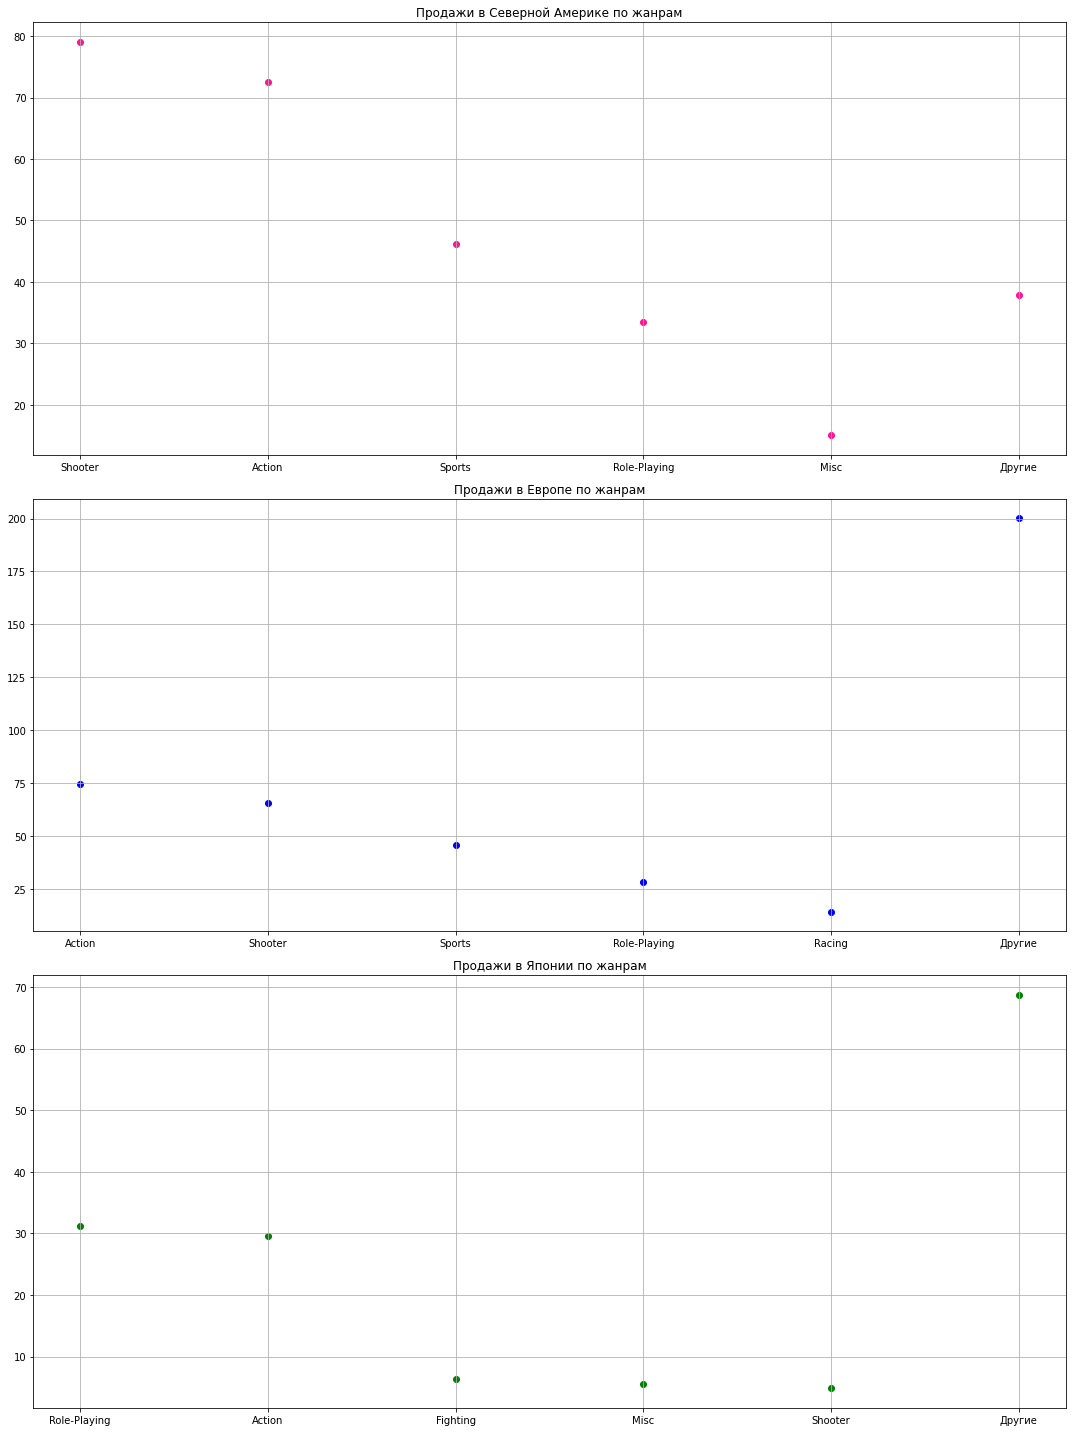

In [46]:
fig, ax = plt.subplots(3, 1, figsize = (15,20))

ax[0].scatter(genres_na['genre'],
           genres_na['na_sales'],
           c = 'deeppink')

ax[1].scatter(genres_eu['genre'],
           genres_eu['eu_sales'],
           c = 'b')

ax[2].scatter(genres_jp['genre'],
           genres_jp['jp_sales'],
           c = 'g')

ax[0].set_facecolor('w')
ax[0].set_title('Продажи в Северной Америке по жанрам')
ax[0].grid(True)

ax[1].set_facecolor('w')
ax[1].set_title('Продажи в Европе по жанрам')
ax[1].grid(True)

ax[2].set_facecolor('w')
ax[2].set_title('Продажи в Японии по жанрам')
ax[2].grid(True)

fig.tight_layout();
plt.show()

**Категория "другие" в Европе и Японии имеет больше всего продаж. Но в Северной америке расположилась лишь на 4-ом месте со значением около 40 млн  
Топ 5 самых популярных жанров для:** 
- Северной Америки: Shooter, Action, Sports, Role-Playing, Misc     
- Европы: Action, Shooter, Sports, Role-Playing, Racing   
- Японии: Role-Playing, Action, Fighting, Misc, Shooter  

### Влияние рейтинга ESRB на продажи в отдельном регионе

**Создадим в df новый столбец с обобщенными категориями - дети младшего возраста, подростки, взрослые. Также добавим категорию "Ожидается" (для статуса RP(рейтинг ожидается))**

In [47]:
def rating_2(row):
    rating = row['rating']
    try:
        if rating in ['E', 'E10+', 'K-A', 'EC']:
            return 'Дети мл. возраста'
        elif rating in ['T', 'M']:
            return 'Подростки'
        elif rating == 'AO':
            return 'Взрослые'
        elif rating == 'RP':
            return 'Ожидается' 
        elif rating == 'unknown':
            return 'Нет рейтинга'
            
    except:
        return rating

**Применим функцию rating_2 к df**

In [48]:
df['rating_category'] = df.apply(rating_2, axis = 1)

**Создадим три сводные таблицы, демонстрирующие продажи игр по категории рейтинга ESRP в каждом регионе**

In [49]:
rating_sales = df.pivot_table(index = 'rating_category', values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')\
        .sort_values(by = 'na_sales', ascending = False).reset_index()

display(rating_sales)

,rating_category,eu_sales,jp_sales,na_sales
0,Дети мл. возраста,887.60,239.62,1623.83
1,Подростки,901.79,214.28,1490.49
2,Нет рейтинга,609.65,836.72,1225.84
3,Взрослые,0.61,0.00,1.26
4,Ожидается,0.03,0.00,0.00


**Построим график**

In [50]:
fig_6 = go.Figure([
    go.Bar(                         
        x = rating_sales['rating_category'], 
        y = rating_sales['na_sales'],
        name = 'NA'
    ),
    go.Bar(                         
        x = rating_sales['rating_category'], 
        y = rating_sales['eu_sales'],
        name = 'EU',
    ),
    go.Bar(                         
        x = rating_sales['rating_category'], 
        y = rating_sales['jp_sales'],
        name = 'JP',
    )
])
fig_6.show()

**Во всех регионах больше всего продаются игры для детей младшего возраста. Так в Северной Америке это 1600 млн проданных копий против 1490 млн в категории для подростков и 1225 млн для игр с неопределенным рейтингом.  
Игры для подростков имеют практически такие же результаты, но по продажам ниже.  
Игры для взрослых продаются только в Европе (610 тыс копий) и Северной америке (1.26 млн копий) и их очень мало, а со статусом "рейтинг ожидается" - только в Европе (30 000 копий)  
Игр без рейтинга очень много в Японии, если смотреть по общему числу игр. Также без рейтинга много игр в Америке и Европе, но значений здесь гораздо больше**

## Проверка гипотез

### Тест №1

**Проверка двусторонней гипотезы:  
Нулевая гипотеза H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые  
Альтернативная гипотеза H1: Средние пользовательские рейтинги платформ Xbox One и PC неодинаковые**

**Проверим периоды использования платформ**

In [51]:
x=df.query('platform == "XOne" and year_of_release > 1985')
print(x['year_of_release'].unique())
y=df.query('platform == "PC" and year_of_release > 1985')
print(y['year_of_release'].unique())

[2015 2014 2013 2016]
[2009 2004 2012 1996 2010 1995 1997 2007 2011 2002 1994 2014 2000 2001
 1992 1998 1999 2003 2013 2008 2015 2005 2016 2006 1988]


**Так как платформа XOne вышла на рынок совсем недавно, а PC используется с 1988 года, нужно уравнять периоды**

In [52]:
# Сделаем срез таблицы df по критериям:
df_Xone = df.query('platform == "XOne"')
df_PC = df.query('platform == "PC" and year_of_release >= 2012')

# Оставим только нужный нам столбец
df_Xone = df_Xone.loc[:,'user_score']
df_PC = df_PC.loc[:,'user_score']

# Выборки практически одинакового размера. Для проверки гипотезы осталось удалить малочисленные пропуски
df_Xone=df_Xone.dropna()
df_PC=df_PC.dropna()


In [53]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df_Xone, df_PC)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


**p-value показывает, какова вероятность получить СЛУЧАЙНО отличающееся значение, а, значит, чем больше p-value, тем больше у нас аргументов, чтобы гипотезу не отвергать. В данном случае с вероятность 55% может произойти это отличие, а значит, гипотезу не отвергаем  
Нулевая гипотеза не отвергнута. Делаем вывод, что средние пользовательские рейтинги платформ PC и XOne одинаковые**

### Тест №2

**Проверка двусторонней гипотезы:  
Нулевая гипотеза H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые  
Альтернативная гипотеза H1: Средние пользовательские рейтинги жанров Action и Sports не одинаковые**

In [54]:
# Сделаем срез таблицы df по критериям:
df_action = df.query('genre == "Action" and year_of_release > 2013')
df_sports = df.query('genre == "Sports" and year_of_release > 2013')

# Оставим только нужный нам столбец
df_action = df_action.loc[:,'user_score']
df_sports = df_sports.loc[:,'user_score']

# Выборки практически одинакового размера. Для проверки гипотезы осталось удалить пропуски
df_action=df_action.dropna()
df_sports=df_sports.dropna()

In [55]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df_action, df_sports)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


**p-value является бесконечно малым, а, значит, вероятность получить такое или большее значение случайно крайне мала, соответственно, гипотезу отвергаем  
Данную гипотезу мы отвергаем, значит, средние пользовательские рейтинги жанров Action и Sports принимаем не одинаковыми.**

## Вывод

**Проведен анализ определяющих успешность игры закономерностей. Была проведена предобработка данных.  
Сделаны следующие выводы:**
- Количество выпущенных игр непрерывно увеличивалось, не считая последней пары лет
- Самыми популярными платформами являются PS4, XOne и 3DS, несмотря на то, что популярность последних двух сильно упала за последние пару лет. Значит, можно спрогнозировать, что игры на этих платформах будут продаваться лучше, чем на остальных
-  Если грубо взглянуть на диаграмму размаха по продажам по платформам, то можно сделать вывод, что медиана и большинство значений находится в диапазоне 0.01 до 0.15, а все, что выше 1 млн переходит в выбросы, т.к. таких значений крайне мало. 
- Также можно спрогнозировать, что лучше продаются игры, имеющие высокую оценку в основном именно у критиков, а не у юзеров
- Стоит учесть большой размах продаж в жанрах Action, Sports, Shooter и Role-Playing за актуальный период. Это значит, что данные жанры будут приносить прибыль и дальше  
Проведен анализ пользователей из разных регионов:    
-  Самые большие продажи в Северной Америке наблюдаются на моделях: PS4, XOne, X360, 3DS, PS3; Европы: PS4, XOne, PS3, PC, 3DS; Японии: 3DS, PS4, PSV, PS3, WiiU. Эти платформы в разбивке по регионам должны приносить больше всего прибыли
- В пятерку самых популярных жанров в трех регионах вошли: Action, Sports, Shooter, Fighting, Misc, Racing, Role-Playing
- Во всех регионах больше всего продаются игры для детей младшего возраста. Игры для подростков имеют практически такие же результаты, но по продажам ниже. Игры для взрослых продаются только в Европе (610 тыс копий) и Северной америке (1.26 млн копий) и их очень мало, а со статусом "рейтинг ожидается" - только в Европе (30 000 копий). Многие игры не имеют рейтинга вообще - это связано с тем, что ESRB работает в основном на домашний рынок (NA) и производители из других регионов не стремятся получить их оценку  
Проверены гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые - не отвергнута. Принимаем, что средние пользовательские рейтинги платформ XOne и PC - одинаковые.
- Средние пользовательские рейтинги жанров Action и Sports разные. Гипотеза была переформулирована: средние пользовательские рейтинги жанров Action и Sports одинаковые - отвергнута. Принимаем, что средние пользовательские рейтинги жанров Action и Sports разные
